## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv') #readign the dataframe
df.head() #exploring the dataset and provided features 

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape #shape of the dataframe

(294478, 5)

**The dataframe has 294,478 rows**

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**However, there are only 290,584 unique users in the dataset, with some duplicates (about 1.3%)**

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

**About 11.97% of users have converted**

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
error1=(df.query('landing_page=="new_page" and group !="treatment"')).user_id.count()
error2=(df.query('landing_page=="old_page" and group !="control"')).user_id.count()
error1+error2

3893

**There are 3893 records where an entry of landing pahe and group do not match (some could be from the duplicates previously mentioned). These would need to be cleaned out.**

f. Do any of the rows have missing values?

In [7]:
df.isnull().mean()

user_id         0.0
timestamp       0.0
group           0.0
landing_page    0.0
converted       0.0
dtype: float64

**A quick look at the dataframe shows that thare are no null values.**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
correct_group1=df.query('landing_page=="new_page" and group =="treatment"') 
correct_group2=df.query('landing_page=="old_page" and group =="control"')
#the same code used to inspect the two errors above but with == instead if !=.
df2=correct_group1.append(correct_group2)
#appending them as a new dataframe
df2.reset_index(drop=True, inplace=True) #reseting the index for the new dataframe
df2.head() #final check

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2.shape

(290585, 5)

**All is clear**

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**The User ID is 773192**

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'] == 773192]
#looking for the two records

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**The two records are almost the same, with a difference of timestamp**

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2=df2.drop_duplicates(subset=['user_id'], keep='first')
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


**The other value (index # 1404) was droped from the dataframe**

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

**The probability of conversion is approximately 11.96%**

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group=="control"').converted.mean()

0.1203863045004612

**Approx 12.04%**

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

**Approx 11.88%**

d. What is the probability that an individual received the new page?

In [18]:
overall_count=df2.user_id.count()
new_page=df2.query('landing_page=="new_page"').user_id.count()
new_page/overall_count

0.50006194422266881

**Almost a 50/50 chance**

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**On a first look at the probabilities it might lead someone to think that the control group (old page) leads to more conversions. However, a more indepth testing with methods such as A/B tests with bootstrapping might lead to a different conclusion.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The initial hypotheses could be written like:**

 - H0:  $p_{new}$ <= $p_{old}$ 
 - H1:  $p_{new}$ > $p_{old}$

**However for simplification, we will use the following**

 - H0:  $p_{new}$ - $p_{old}$ <= 0 
 - H1:  $p_{new}$ - $p_{old}$ > 0



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
conv_rate=df2.converted.mean()
conv_rate

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
#Should be the same as Pnew as per the assumptions
conv_rate

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
nnew_count=df2.query('landing_page=="new_page"').user_id.count()
nnew_count

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
nold_count=df2.query('landing_page=="old_page"').user_id.count()
nold_count

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
#binomial simulation
new_page_converted=np.random.binomial(n=nnew_count,p=conv_rate)/nnew_count
new_page_converted

0.11946184020370243

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted=np.random.binomial(n=nold_count,p=conv_rate)/nold_count
old_page_converted

0.11955339565235348

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
differences=new_page_converted-old_page_converted
differences #the observed differences

-9.1555448651053917e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
#generating a sampling distribution
p_diffs=[] 
for i in range (10000):

    new_page_converted0=np.random.binomial(n=nnew_count,p=conv_rate)/nnew_count
    old_page_converted0=np.random.binomial(n=nold_count,p=conv_rate)/nold_count
    difference=new_page_converted0-old_page_converted0
    p_diffs.append(new_page_converted0-old_page_converted0)
    
p_diffs=np.array(p_diffs)
p_diffs


 

array([ -8.62365737e-04,   9.40701616e-04,   9.20301673e-04, ...,
        -1.58756860e-05,   1.76981222e-04,  -1.53005588e-03])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

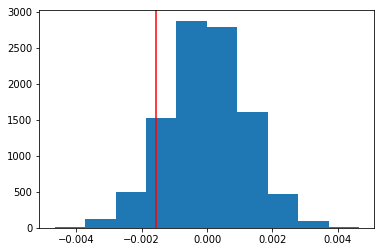

In [27]:
plt.hist(p_diffs); #plotting the differene distributuion
actual_difference=df2.query("landing_page=='new_page'").converted.mean()-df2.query("landing_page=='old_page'").converted.mean()
#calculating the actual difference of conversion between the pages from the dataset
plt.axvline(x=actual_difference,color='r'); #plotting the original actual diffrences in the chart

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs>actual_difference).mean() #this is the p-value

0.90349999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This number represents differrence between the Actual Observed Difference of the conversion rates of the two pages under the null hypotheses, and the proportion of the simulated differences that have a bigger value.**
**The figure is called the "p-value", and its role is important in finding statistical evidence that a hypothesis is true.**
**Given that the original assumption gave a Type I error threshold of 0.05, which the p-value has to be lower than it to be able to reject the Null Hypothesis, the result shown here fails to reject the Null Hypothesis.**


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'").converted.sum()
convert_new = df2.query("landing_page == 'new_page'").converted.sum()
n_old = df2.query("landing_page == 'old_page'").converted.count()
n_new = df2.query("landing_page == 'new_page'").converted.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
ztest, p_value = sm.stats.proportions_ztest((convert_new, convert_old), (n_new, n_old), alternative='larger') 
#the larger part due to the null hypothesis format
ztest, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score here, calcualted through one tail, describes the distance from the mean after standerdizing the normal distribution around 0. Naturally, the negative value means that the actual difference lies on the left of the distribution, which matches the red line on the histogram plot.**
**The p-value generated by the test is a one  close to the one calculated through the sampling distribution in parts (h-j). Similar to the previous outcome we had, the p-value here fails to reject the Null Hypothesis under a Type I error threshold of 0.05**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**This type of data would use the Logistic Regression, since it deals with two values**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept']=1 #adding the intercept
df2[['ab_page2','ab_page']]=pd.get_dummies(df2['group']) #adding two columns for the dummies
df2.drop('ab_page2',axis=1,inplace=True) #dropping the second column, since technically we only use one
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
reg=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result=reg.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
result.summary2() 
#for some reason the .summary gives an error, a quick search lead me to .summary2 instead
#the solution was taken from Stackoverflow, see notes at the end

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-03 21:35 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [34]:
1/np.exp(result.params) #getting the expontiation of the coefficients since this is a logestic regression model
#the inverse is due to the negative value

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value we have here for ab_page is approx 0.19, a number different than the 0.905 calculated in Part II. The diffrent number here is due to the different nature of the way hypothesis are created and measured. In Part II the Null hypothesis focused on that the Old Page had the same or higher conversion rate than the New Page, while the one null hypothesis provided here measures whether there is a difference or not (i.e. One-Tailed vs Two-Tailed analysis). However, in both methods we fail to reject the Null Hypothesis due to high p-value.**



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more factors to the regression model would be useful in comparing multiple features and the significance of their impact in predicting the conversion. The above model is limiting since factors other than the page could have some significant impact that should be considered in the conclusion.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
countries=pd.read_csv('countries.csv') #reading the countries csv
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
df_countries=df2.merge(countries) #merging/joining the two dataframes
df_countries.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [37]:
#creating dummies for the country column
df_countries[['CA','UK','US']]=pd.get_dummies(df_countries['country']) 
#the columns filled by the dummies are apparently sorted alphatbetically


In [38]:
df_countries.drop('US',axis=1,inplace=True) #dropping the US column since we would not need it
df_countries.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0


In [39]:
reg=sm.Logit(df_countries['converted'],df_countries[['intercept','ab_page','CA','UK']])
result=reg.fit()
result.summary2() 

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-03 21:35 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [40]:
np.exp(result.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [41]:
1/np.exp(result.params) #relavent for CA since it has a negative coefficient value.

intercept    7.310207
ab_page      1.015056
CA           1.041599
UK           0.990165
dtype: float64


**Looking at the p-values for all the factors in the comparison, none appear to be statistically significant compared to the given Type I error threshold of 0.05**

**In addition, looking at the exponentiated coefficients, and holding all other variables constant, the countries do not appear to have a multiplicative effect on the conversion rate (e.g. for Canadian they are 1.042 as likely to convert)**


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
#reflecting on project feedback
#creating the interaction columns
df_countries['CA_page'] = df_countries['CA'] * df_countries['ab_page']
df_countries['UK_page'] = df_countries['UK'] * df_countries['ab_page']
df_countries.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,CA_page,UK_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,1,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,1,0


In [43]:
reg=sm.Logit(df_countries['converted'],df_countries[['intercept','CA_page','UK_page']])
result=reg.fit()
result.summary2() 

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-03 21:35 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
CA_page      -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
UK_page       0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

In [44]:
np.exp(result.params)

intercept    0.135840
CA_page      0.927579
UK_page      1.015000
dtype: float64

In [45]:
1/np.exp(result.params) #relavent for CA since it has a negative coefficient value.

intercept    7.361591
CA_page      1.078076
UK_page      0.985222
dtype: float64

**Interestingly, when looking at the interaction between BOTH the country and the landing page and their effect on conversion, it seems that CA_page (Canadian visitors and type of page) give a p-value of 0.0458, whcih is below our threshold of 0.05 for Type I errors, making it statistically significant.**

**Looking at the exponentiated coefficients, the Canadian and Page interaction has multiplicative effect of 1.078 on the conversion rate.**

**Although statistically though could mean that we should focus on Canadian visitors, however this could raise a question of whether it is practical to give it much attention, given that only 5% of the website visitors are Canadian**



In [46]:
# % of visitors 
df_countries.country.value_counts()/df_countries.country.count()

US    0.700723
UK    0.249381
CA    0.049896
Name: country, dtype: float64

<a id='conclusions'></a>
## Finishing Up and Conclusions


**The sections above attempted to analyze the comparision of the conversion rate resulted two versions of a webpage (Old vs New), from manual probability calculation to A/B Tests and Regression Analysis.**

**From looking at the results, in both A/B testing and Regression Analysis we fail to reject the Null Hypotheses.**

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Notes 
**1. For the Summary2() note, the solution for the error was taken from the StackOverflow post below. The same error was occurring the the lessons**

https://stackoverflow.com/questions/49814258/statsmodel-attributeerror-module-scipy-stats-has-no-attribute-chisqprob

**2. There were some code changes based on Udacity submission review feedback**


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0